# Proximal Policy Optimization and the Cartpole 

The cartpole is a control theory task where the goal is to balance a pole on a cart that sits on a one dimensional track.  You can push the cart left and right to balance the pole.

In this lecture we will use a neural network to learn a policy that tells us whether to push the cart left or right depending on the angle of the pole, the position of the cart, and the velocity of the cart.

We will train this neural network using reinforcement learning.  This is a technique where you have the agent (the neural network) run through the task over and over again, and update its policy (parameters of the neural network) based on its performance.

There are many algorithms that do reinforcement learning.  In this notebook we will use one called **Proximal Policy Optimization**.  

This code comes from https://github.com/RPC2/PPO

# Clones, Installs, Imports

## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/reinforcement_learning_tutorial

import os
os.chdir("reinforcement_learning_tutorial")

fatal: destination path 'reinforcement_learning_tutorial' already exists and is not an empty directory.


## Install Packages

In [2]:
%%time
!pip install pyvirtualdisplay ptan
!pip install gym[classic_control]
!apt-get install -y xvfb python-opengl ffmpeg 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
CPU times: user 126 ms, sys: 40 ms, total: 166 ms
Wall time: 13.4 s


## Import Librarires

There are three main libraries we will import.

1) `gym` - this has the simulation environment. 

2) `torch` - this does the neural network training.  

3) `ptan` - this has the agent wrapper we need to have the agent interact with the simulator.  

The other libraries help with visualizing the simulation.

In [3]:
from scripts.rl_helper import *
import gym, os
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation

import ptan
import torch


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import count
import torch
from torch.distributions import Categorical

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Cartpole Environment
The name of the simulator environment is `"CartPole-v1"`, which we save to a variable `env_name`.  We can load the cart pole simulator environment with the `gym.make` function.  We use the `wrap_env` function so we can visualize the output of the simulator in Colab.

Note: You can load many different gym simulator environments with this line of code.  Just change `env_name`.  You can find a list of the gym environments here: https://www.gymlibrary.dev/

## Create Environment

In [4]:
env_name = "CartPole-v1"
#env_name = "MountainCar-v0"
env = gym.make(env_name,new_step_api=True)

query_environment(env_name)


Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 475.0


## Visualize Environment

This code will run through the simulator and visualize it.  We use a random choice for the `action` of the agent.  The simulation stops when the pole tilts too far to the right or too far to the left. The score of the agent is the number of steps the simulation runs for, with a maximum value of 500.

The `show_video` function has the simulation loop.
Each time we run a step in the simulator,  we give an `action`, and the `env.step` function returns an `observation` of the state (pole angle, pole angular velocity, cart position, cart velocity), the current `reward` (it is 1 always), and a `done` variable that is `TRUE` if the pole tilted too far, or if we went 500 steps. 

We start the simulator by doing `env.reset()`, then use a `for` loop to run through the simulator one step at a time.  At the end we print out the score of the agent (how long it could balance the pole for), and we show a video of the agent balancing the pole on the cart.

CartPole-v1 score = 18.0


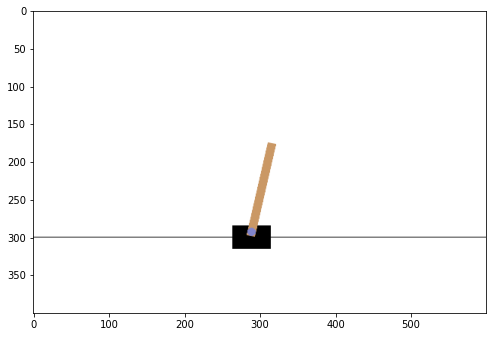

In [5]:
score = show_video(env)
print(f"{env_name} score = {score}")


# PPO Neural Network 

In [6]:
class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01

    # Memory
    memory_size = 400

    train_cartpole = True

class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=4):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x


# PPO Training Code

Input the `env_name` and the `winning_score` when initializing the `Agent` class.

In [7]:
class Agent(AgentConfig):
    def __init__(self, env_name,winning_score):
        self.env = gym.make(env_name,new_step_api=True)
        self.winning_score = winning_score
        self.action_size = self.env.action_space.n  # 2 for cartpole
        self.policy_network = MlpPolicy(action_size=self.action_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }
        #print(f"Created environment for {}")

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        #screen, reward, terminal, info = self.env.step(action)
        screen, reward,  terminal1 , terminal2, _ = self.env.step(action)
        terminal = terminal1 | terminal2
        return screen, reward, action, terminal

    def train(self):
        episode = 0
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        # A new episode
        while not solved:
            start_step = step
            episode += 1
            episode_length = 0

            # Get initial state
            state, reward, action, terminal = self.new_random_game()
            current_state = state
            total_episode_reward = 1

            # A step in an episode
            while not solved:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(torch.FloatTensor(current_state).to(device))
                # print(prob_a)
                action = torch.distributions.Categorical(prob_a).sample().item()

                # Act
                state, reward, terminal1, terminal2, _ = self.env.step(action)
                terminal = terminal1 | terminal2
                new_state = state

                reward = -1 if terminal else reward

                self.add_memory(current_state, action, reward/10.0, new_state, terminal, prob_a[action].item())

                current_state = new_state
                total_episode_reward += reward

                if terminal:
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    score_mean = sum(reward_history[-10:])/10.0

                    self.finish_path(episode_length)

                    #if len(reward_history) > 100 and sum(reward_history[-100:-1]) / 100 >= 195:
                    #    solved = True
                    if score_mean > self.winning_score:
                        solved = True
                        print(f'DONE!\nEpisode: {episode}, Score: {total_episode_reward:.1f}, Mean Score = {score_mean:.1f}')
                        break
                    if episode%10 ==0:
                        #print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                        #  'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                        #                            self.scheduler.get_lr()[0]))
                        print(f'Episode: {episode}, Score: {total_episode_reward:.1f}, Mean Score = {score_mean:.1f}')

                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()



        self.env.close()
        return reward_history

    def update_network(self):
        # get ratio
        pi = self.policy_network.pi(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']).to(device))
        old_probs_a = torch.FloatTensor(self.memory['action_prob']).to(device)
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.FloatTensor(self.memory['advantage']).to(device)
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage']).to(device)
        pred_v = self.policy_network.v(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - self.memory['td_target']).pow(2)  # Huber loss
        v_loss = v_loss.to(device)
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy]).to(device)

        #print(f"Actor: surr1 {surr1.device}, surr2 {surr2.device}, pred_v {pred_v.device}, v_loss {v_loss.device}, ")
        #print(f"Critic: v_loss {v_loss.device}")
        #print(f"Entrop {entropy.device}")

        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]


        td_target = torch.FloatTensor(reward).to(device) + \
                    self.gamma * self.policy_network.v(torch.FloatTensor(next_state).to(device)) * \
                    torch.FloatTensor(terminal).to(device)
        delta = td_target - self.policy_network.v(torch.FloatTensor(state).to(device))
        delta = delta.detach().cpu().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'].to(device), td_target.data), dim=0)
        self.memory['advantage'] += advantages






# Train PPO Agent

In [9]:
winning_score = 490
agent = Agent(env_name, winning_score)
scores = agent.train()

DONE!
Episode: 10, Score: 9.0, Mean Score = 20.5
DONE!
Episode: 20, Score: 87.0, Mean Score = 46.8
DONE!
Episode: 30, Score: 130.0, Mean Score = 72.9
DONE!
Episode: 40, Score: 158.0, Mean Score = 159.2
DONE!
Episode: 50, Score: 120.0, Mean Score = 162.8
DONE!
Episode: 60, Score: 134.0, Mean Score = 153.8
DONE!
Episode: 70, Score: 127.0, Mean Score = 190.7
DONE!
Episode: 80, Score: 140.0, Mean Score = 153.7
DONE!
Episode: 90, Score: 185.0, Mean Score = 149.1
DONE!
Episode: 100, Score: 128.0, Mean Score = 155.4
DONE!
Episode: 110, Score: 159.0, Mean Score = 160.3
DONE!
Episode: 120, Score: 296.0, Mean Score = 235.9
DONE!
Episode: 130, Score: 498.0, Mean Score = 469.5
Episode: 133, Score: 498.0, Mean Score = 498.0


## Save Trained Agent

We will only save the neural network, and not the other stuff.

In [11]:
torch.save(agent.policy_network, 'actor.pkl')

## Plot Agent's Performance vs Episode
Plot the average score of the actor (how long it balanced the pole for) versus the training episode number for policy gradient and policy gradient with baseline.  We smooth the plots over multiple episodes to make a prettier plot.

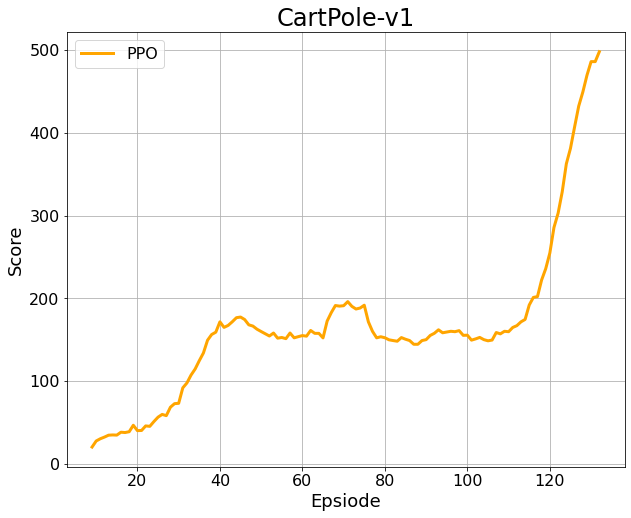

In [19]:
window = 10
df = pd.DataFrame({'episode':[x for x in range(len(scores))],
                   'score':scores})
df['score_smooth'] = df.score.rolling(window=window).mean()

fig = plt.figure(figsize = (10,8))
sns.lineplot(data = df, x = 'episode', y = 'score_smooth', 
             color = 'orange', label='PPO', linewidth = 3)
plt.legend(fontsize = 16)
plt.ylabel('Score',fontsize = 18)
plt.xlabel('Epsiode', fontsize = 18)
plt.title(f"{env_name}", fontsize = 24)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()



# Test Trained Agent

## Load the Trained Agent
You can load the trained agent you saved.  Make sure you have the right filename.


In [ ]:
#Load trained agent
agent =  torch.load('actor.pkl')
agent.eval()


## Run Trained Agent in Enviornment
This cell lets you see how the trained agent performs.

CartPole-v1 with trained agent: score = 500.0


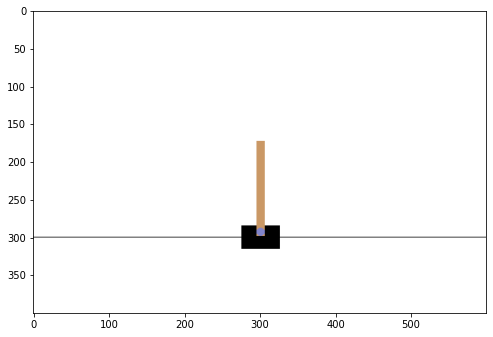

In [17]:
d = Display()
d.start()
state = env.reset()

img = []
score = 0
for _ in range(10000):
    if agent==None:
      action = env.action_space.sample()
    else:
      prob_a = agent.pi(torch.FloatTensor(state).to(device))
      action = torch.distributions.Categorical(prob_a).sample().item()



    state, reward, terminated, truncated , info = env.step(action) # Take action from DNN in actual training.
    display.clear_output(wait=True)
    img.append(env.render('rgb_array'))
    score+=reward
    if terminated or truncated:
        env.reset()
        break

dpi = 72
interval = 20 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))
print(f"{env_name} with trained agent: score = {score}")


In [35]:
agent.device

AttributeError: ignored